# Benchmarking Numberlink Solvers

In [ ]:
import sys
import os

# Add the `backend` folder to the path
sys.path.append(os.path.abspath("../backend"))

In [5]:
import time

from constraint_solver_path import ConstraintPathSolver
from pyco_solver_path import PycoPathSolver
from pyco_solver_edge import PycoEdgeSolver

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

ModuleNotFoundError: No module named 'constraint_solver_path'

In [22]:
def run_constraint_path_solver(puzzle):
    solver = ConstraintPathSolver(puzzle)
    return solver.solve()


def run_pyco_path_solver(puzzle):
    solver = PycoPathSolver(puzzle)
    return solver.solve()


def run_pyco_edge_solver(puzzle):
    solver = PycoEdgeSolver(puzzle)
    return solver.solve()


solvers = {
    "ConstraintPathSolver": run_constraint_path_solver,
    "PycoPathSolver": run_pyco_path_solver,
    "PycoEdgeSolver": run_pyco_edge_solver,
}

In [23]:
def benchmark_solver(solver, puzzles):
    times = []
    for index in range(len(puzzles)):
        puzzle = puzzles[index]
        start_time = time.time()
        if solver(puzzle) is None:
            print(f"Failed to solve puzzle {index}")
            continue
        end_time = time.time()
        print(f"Solved puzzle {index} in {end_time - start_time} seconds")
        times.append(end_time - start_time)
    return times

In [24]:
import signal
import time


def timeout_handler(signum, frame):
    raise TimeoutError("Function execution exceeded the time limit!")


def run_with_timeout(func, timeout, *args, **kwargs):
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(timeout)

    try:
        result = func(*args, **kwargs)
        return result
    except TimeoutError:
        return None
    finally:
        signal.alarm(0)

In [25]:
import json

with open("puzzles.json", "r") as f:
    puzzles = json.load(f)
    puzzles.sort(key=lambda x: x["dimension"])
puzzle_sizes = [puzzle["dimension"] for puzzle in puzzles]
puzzle_sizes

[4, 5, 6, 7, 8, 9, 10, 11]

In [26]:
MAX_RUNTIME = 1  # seconds

In [27]:
from tqdm import tqdm

results = {"Solver": [], "Puzzle Set": [], "Puzzle Number": [], "Time (s)": []}
NUM_PUZZLES_TO_SOLVE = 200

for solver_name, solver in solvers.items():
    for puzzle in puzzles:
        dimension = puzzle["dimension"]
        grids = puzzle["grids"]
        if len(grids) < NUM_PUZZLES_TO_SOLVE:
            print(
                f"Warning: Not enough puzzles for {solver_name} {dimension}x{dimension}"
            )
        grids = grids[:NUM_PUZZLES_TO_SOLVE]
        for i, grid in tqdm(
            enumerate(grids, 1),
            desc=f"{solver_name} {dimension}x{dimension}",
            total=len(grids),
        ):
            start_time = time.time()
            if run_with_timeout(solver, MAX_RUNTIME, grid) is None:
                # print(f"Failed to solve puzzle {i}")
                break
            end_time = time.time()
            # print(f"Solved puzzle {i} in {end_time - start_time} seconds")
            results["Solver"].append(solver_name)
            results["Puzzle Set"].append(f"{dimension}x{dimension}")
            results["Puzzle Number"].append(i)
            results["Time (s)"].append(end_time - start_time)

df_results = pd.DataFrame(results)

PycoPathSolver 11x11:   0%|          | 0/200 [00:00<?, ?it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105fd34c0>>
Traceback (most recent call last):
  File "/Users/arushmehrotra/Library/Caches/pypoetry/virtualenvs/numberlink-iC17Ysb4-py3.10/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
  File "/var/folders/fz/jm758_112tx9f82tdcr2_tnm0000gn/T/ipykernel_89043/1828055152.py", line 5, in timeout_handler
TimeoutError: Function execution exceeded the time limit!
PycoEdgeSolver 11x11: 100%|██████████| 200/200 [00:40<00:00,  4.97it/s]


In [28]:
df_results.to_csv("results.csv", index=False)

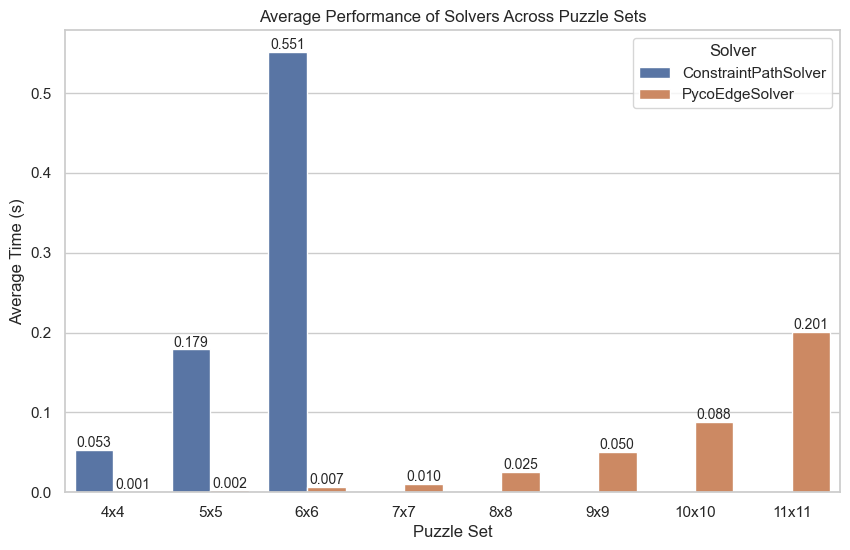

In [37]:
# Set style for the plot
sns.set(style="whitegrid")

# Create the bar plot without error bars
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x="Puzzle Set", y="Time (s)", hue="Solver", data=df_results, errorbar=None
)
plt.title("Average Performance of Solvers Across Puzzle Sets")
plt.xlabel("Puzzle Set")
plt.ylabel("Average Time (s)")
plt.legend(title="Solver")

# Add the values on top of the bars
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

plt.show()